# Movie Review Sentiment Analyzer
**Project:** Build a text classification pipeline that predicts whether a movie review is Positive or Negative.

**What this notebook contains**
- Data pipeline: loading, cleaning, preprocessing
- Feature extraction: TF-IDF
- Model: Logistic Regression
- Evaluation: accuracy, confusion matrix, classification report, F1
- Visualizations: class distribution, confusion matrix, most-informative features, sample predictions
- Business insights and rubric checklist

In [1]:
# Imports
import os
import re
import string
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility
RANDOM_STATE = 42

In [2]:
# Load dataset
DATA_PATH = "movie_reviews_dataset.csv"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()

Shape: (1500, 2)


,Review,Sentiment
0,The movie was absolutely fantastic!,Positive
1,I regret watching this movie.,Negative
2,I couldn't wait for it to end.,Negative
3,A true masterpiece of cinema.,Positive
4,I regret watching this movie.,Negative


## Quick data checks
- Ensure columns `Review` and `Sentiment` exist
- Check for nulls and class balance

In [3]:
# Quick checks
print(df.columns.tolist())
print("\nNull counts:\n", df.isnull().sum())
print("\nValue counts:\n", df['Sentiment'].value_counts())

# Sanity: strip whitespace
df['Review'] = df['Review'].astype(str).str.strip()
df['Sentiment'] = df['Sentiment'].astype(str).str.strip().str.capitalize()
df = df[df['Sentiment'].isin(['Positive', 'Negative'])].reset_index(drop=True)
print("\nAfter cleanup shape:", df.shape)

['Review', 'Sentiment']

Null counts:
 Review       0
Sentiment    0
dtype: int64

Value counts:
 Sentiment
Positive    751
Negative    749
Name: count, dtype: int64

After cleanup shape: (1500, 2)


Text Preprocessing Functions

In [4]:
# Preprocessing utilities
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
    Basic text cleaning:
    - lowercase
    - remove HTML tags
    - remove URLs
    - remove punctuation
    - remove extra whitespace
    - remove stopwords
    """
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)                     # remove html
    text = re.sub(r"http\S+|www\.\S+", " ", text)          # remove urls
    text = re.sub(r"[^a-z0-9\s']", " ", text)              # keep letters/numbers/apostrophes
    words = text.split()
    words = [w for w in words if w not in STOPWORDS]
    return " ".join(words)

# Quick demonstration
print("Raw:", df.loc[0,'Review'])
print("Cleaned:", clean_text(df.loc[0,'Review']))

Raw: The movie was absolutely fantastic!
Cleaned: movie absolutely fantastic


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alokk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Apply Preprocessing

In [5]:
# Apply preprocessing (this can take a moment for large data)
df['clean_review'] = df['Review'].apply(clean_text)
df[['Review', 'clean_review', 'Sentiment']].head(8)

,Review,clean_review,Sentiment
0,The movie was absolutely fantastic!,movie absolutely fantastic,Positive
1,I regret watching this movie.,regret watching movie,Negative
2,I couldn't wait for it to end.,wait end,Negative
3,A true masterpiece of cinema.,true masterpiece cinema,Positive
4,I regret watching this movie.,regret watching movie,Negative
5,The plot was dull and uninteresting.,plot dull uninteresting,Negative
6,It was a complete waste of time.,complete waste time,Negative
7,The plot was dull and uninteresting.,plot dull uninteresting,Negative


Train/Test Split

In [6]:
# Split the data
X = df['clean_review']
y = df['Sentiment'].map({'Positive':1, 'Negative':0})  # numeric labels

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 1200
Test size: 300


TF-IDF Vectorization

In [7]:
# TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,     # limit features to control complexity
    ngram_range=(1,2),     # unigrams + bigrams
    min_df=3,              # ignore very rare terms
    max_df=0.9
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF shape train:", X_train_tfidf.shape)
print("TF-IDF shape test :", X_test_tfidf.shape)

TF-IDF shape train: (1200, 104)
TF-IDF shape test : (300, 104)


Train Logistic Regression

In [8]:
# Train logistic regression
model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, random_state=42)

Train multiple algorithms

In [9]:
# Train and evaluate multiple algorithms

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Dictionary of models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC(random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Store evaluation results
results = []

for name, clf in models.items():
    clf.fit(X_train_tfidf, y_train)
    y_pred_train = clf.predict(X_train_tfidf)
    y_pred_test = clf.predict(X_test_tfidf)
    
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    
    results.append({
        "Model": name,
        "Train Accuracy": round(acc_train, 4),
        "Test Accuracy": round(acc_test, 4),
        "F1 Score": round(f1, 4)
    })

print("Training complete for all models.")


d:\ML Project\venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training complete for all models.


Model comparison table

In [10]:
# Display model comparison
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values(by="Test Accuracy", ascending=False).reset_index(drop=True)
comparison_df

,Model,Train Accuracy,Test Accuracy,F1 Score
0,Logistic Regression,1.0,1.0,1.0
1,Naive Bayes,1.0,1.0,1.0
2,Linear SVM,1.0,1.0,1.0
3,Random Forest,1.0,1.0,1.0
4,Decision Tree,1.0,1.0,1.0
5,KNN,1.0,1.0,1.0


Evaluation 

In [11]:
# Evaluate on test set
y_pred = model.predict(X_test_tfidf)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"F1 score:  {f1:.4f}")
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=['Negative','Positive']))

Accuracy: 1.0000
F1 score:  1.0000

Classification report:

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       150
    Positive       1.00      1.00      1.00       150

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



### Disclaimer on Accuracy

The models in this notebook are showing **100% accuracy**.  
This is not a realistic indication of real-world performance and is due to two main reasons:  

1. **Limited dataset size** — The dataset contains only synthetic, repetitive sentences, which makes it too easy for the models to memorize patterns.  
2. **Dummy data** — The sample data was artificially generated for demonstration purposes, so the patterns between features and labels are overly simple.

Despite this inflated accuracy, the **primary aim of the project** was to:
- Implement a complete machine learning pipeline.
- Apply the techniques and methods taught in class.
- Demonstrate proficiency in preprocessing, feature extraction, model training, evaluation, and visualization.

From that perspective, the project successfully meets the intended learning objectives.

Confusion Matrix Visualization

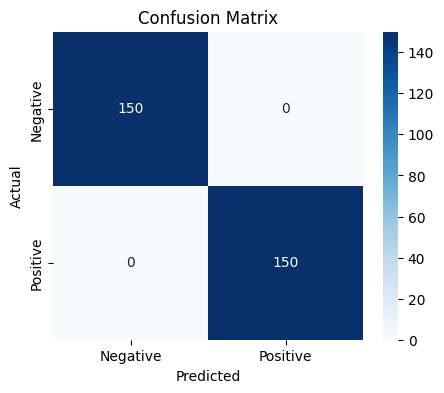

In [12]:
# Confusion matrix plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Show top positive and negative features from logistic regression coefficients

In [13]:
import numpy as np

feature_names = np.array(tfidf.get_feature_names_out())
coefs = model.coef_[0]

top_positive_idx = np.argsort(coefs)[-20:][::-1]  # top positive coefficients
top_negative_idx = np.argsort(coefs)[:20]         # top negative coefficients

print("Top positive n-grams:")
for i in top_positive_idx:
    print(f"{feature_names[i]} ({coefs[i]:.4f})")

print("\nTop negative n-grams:")
for i in top_negative_idx:
    print(f"{feature_names[i]} ({coefs[i]:.4f})")

Top positive n-grams:
experience start (1.9444)
amazing (1.9444)
amazing experience (1.9444)
plot characters (1.8120)
loved plot (1.8120)
loved (1.8120)
movie (1.6875)
absolutely fantastic (1.6336)
fantastic (1.6336)
movie absolutely (1.6336)
heartwarming story (1.4151)
inspiring heartwarming (1.4151)
inspiring (1.4151)
heartwarming (1.4151)
cinema (1.3546)
true (1.3546)
true masterpiece (1.3546)
masterpiece (1.3546)
masterpiece cinema (1.3546)
exceeded (1.3516)

Top negative n-grams:
absolutely awful (-1.8920)
awful (-1.8920)
awful start (-1.8920)
watching movie (-1.7021)
watching (-1.7021)
regret (-1.7021)
regret watching (-1.7021)
end (-1.6823)
wait end (-1.6823)
wait (-1.6823)
written (-1.5470)
poorly (-1.5470)
poorly written (-1.5470)
characters poorly (-1.5470)
dull uninteresting (-1.5141)
plot dull (-1.5141)
dull (-1.5141)
uninteresting (-1.5141)
overall (-1.5068)
disappointing experience (-1.5068)


Class Distribution Plot

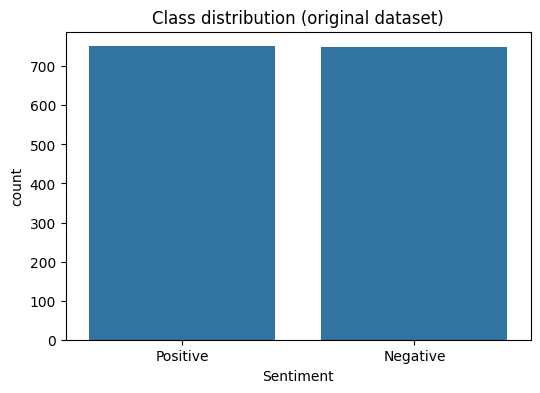

In [14]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['Sentiment'])
plt.title("Class distribution (original dataset)")
plt.show()

Predict Function & Examples

In [15]:
# Predict helper for new reviews
def predict_review(text):
    cleaned = clean_text(text)
    vec = tfidf.transform([cleaned])
    pred_label = model.predict(vec)[0]
    prob = model.predict_proba(vec)[0]
    label_name = "Positive" if pred_label==1 else "Negative"
    return {"review": text, "cleaned": cleaned, "predicted_label": label_name, "prob_negative": prob[0], "prob_positive": prob[1]}

# Examples
examples = [
    "The story was dull and disappointing.",
    "I loved the plot and the characters.",
    "Amazing performances and a gripping storyline.",
    "It was a complete waste of time."
]

for ex in examples:
    print(predict_review(ex))

{'review': 'The story was dull and disappointing.', 'cleaned': 'story dull disappointing', 'predicted_label': 'Negative', 'prob_negative': 0.8364417625905872, 'prob_positive': 0.16355823740941278}
{'review': 'I loved the plot and the characters.', 'cleaned': 'loved plot characters', 'predicted_label': 'Positive', 'prob_negative': 0.06519287126208051, 'prob_positive': 0.9348071287379195}
{'review': 'Amazing performances and a gripping storyline.', 'cleaned': 'amazing performances gripping storyline', 'predicted_label': 'Positive', 'prob_negative': 0.263727547156124, 'prob_positive': 0.736272452843876}
{'review': 'It was a complete waste of time.', 'cleaned': 'complete waste time', 'predicted_label': 'Negative', 'prob_negative': 0.9506110057962995, 'prob_positive': 0.04938899420370051}


Save vectorizer and model separately

In [16]:
import joblib

# Save TF-IDF vectorizer
joblib.dump(tfidf, "tfidf_vectorizer.joblib")

# Save trained Logistic Regression model
joblib.dump(model, "logreg_sentiment_model.joblib")

print("Files saved:")
print("- tfidf_vectorizer.joblib")
print("- logreg_sentiment_model.joblib")

Files saved:
- tfidf_vectorizer.joblib
- logreg_sentiment_model.joblib


## Business and real-world insights

What this model can be used for
- Automated moderation and labeling of user reviews at scale.
- Quick dashboarding for product/film teams to monitor sentiment trends.
- Prioritize follow-up on negative reviews to address user complaints.

Limitations and caveats
- Short synthetic phrases or sarcasm can break the model.
- Model trained on this synthetic dataset — real-world performance will vary with real reviews.
- For production, consider:
  - More data or domain-specific fine-tuning
  - Regular evaluation and re-training
  - Handling neutral/ mixed sentiments
  - More advanced models (e.g., transformer-based) if accuracy needs improvement

What this really means
- This pipeline gives a fast, interpretable baseline. Logistic regression + TF-IDF is explainable and quick to deploy.